In [1]:
#ツイートのテキスト読み込み
test = open("RNN_tweet/Datas/N_extract_tweet.txt", "r", encoding="utf-8")
lines = test.readlines()
test.close()
print(len(lines))

#ラベル読み込み
test = open("RNN_tweet/Datas/label.txt", "r", encoding="utf-8")
label = test.readlines()
test.close()
print(len(label))

10000
10000


In [2]:
from gensim.models import word2vec

data = word2vec.LineSentence('RNN_tweet/Datas/N_extract_tweet.txt')
w2v = word2vec.Word2Vec(size = 200, window=10, hs= 1, sg=1)
w2v.build_vocab(data)
w2v.train(data, total_examples=w2v.corpus_count, epochs=w2v.iter)

G:\ganda\conda\tensorflow_test\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
G:\ganda\conda\tensorflow_test\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(584699, 761865)

In [3]:
from gensim.models.keyedvectors import KeyedVectors

embedding_layer = w2v.wv.get_keras_embedding(train_embeddings=True)

Using TensorFlow backend.


In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical

maxlen = 50
training_samples = 8000 # training data 80 : validation data 20
validation_samples = len(lines) - training_samples
max_words = 20000

# word indexを作成
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

data = pad_sequences(sequences, maxlen=maxlen)

# バイナリの行列に変換
categorical_labels = to_categorical(label)
labels = np.asarray(categorical_labels)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
datas = data[indices]
labels = labels[indices]

x_train = datas[:training_samples]
y_train = labels[:training_samples]
x_val = datas[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [6]:
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, LSTM

sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
preds = Dense(y_train.shape[1], activation='softmax')(x)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

#early_stopping = EarlyStopping(patience=0, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 200)           1002000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 1,170,706
Trainable params: 1,170,706
Non-trainable params: 0
_________________________________________________________________


NameError: name 'EarlyStopping' is not defined

In [7]:
history = model.fit(x_train, y_train,
                    epochs=50, 
                    batch_size=300,
                    validation_data=(x_val, y_val))

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 4s 489us/step - loss: 0.6147 - acc: 0.6224 - val_loss: 0.5867 - val_acc: 0.6635
Epoch 2/50
8000/8000 [==============================] - 3s 314us/step - loss: 0.5048 - acc: 0.7439 - val_loss: 0.5571 - val_acc: 0.7150
Epoch 3/50
8000/8000 [==============================] - 3s 320us/step - loss: 0.4316 - acc: 0.8015 - val_loss: 0.5343 - val_acc: 0.7235
Epoch 4/50
8000/8000 [==============================] - 2s 312us/step - loss: 0.3794 - acc: 0.8285 - val_loss: 0.5577 - val_acc: 0.7300
Epoch 5/50
8000/8000 [==============================] - 2s 309us/step - loss: 0.3262 - acc: 0.8601 - val_loss: 0.5732 - val_acc: 0.7395
Epoch 6/50
8000/8000 [==============================] - 3s 314us/step - loss: 0.2800 - acc: 0.8806 - val_loss: 0.6085 - val_acc: 0.7380
Epoch 7/50
8000/8000 [==============================] - 3s 314us/step - loss: 0.2451 - acc: 0.8973 - val_loss: 0.6594 - val_acc: 0.7445


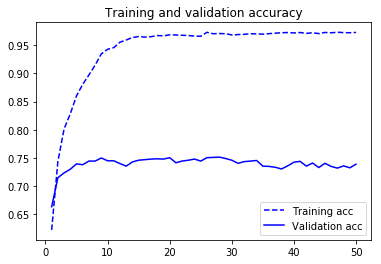

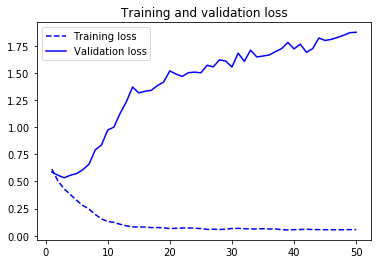

<Figure size 432x288 with 0 Axes>

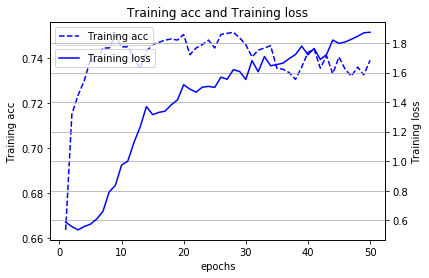

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
#precision = history.history['macro_precision']
#val_precision = history.history['val_macro_precision']
#recall = history.history['macro_recall']
#val_recall = history.history['val_macro_recall']
#f_measure = history.history['macro_f_measure']
#val_f_measure = history.history['val_macro_f_measure']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Training acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Training loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Training acc and Training loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Training acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Training loss')

#plt.savefig("acc_loss.png")
plt.show()